In [1]:
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
import COSMOS_Astrometry
from functools import partial
import collections
from scarlet_extensions.initialization.detection import makeCatalog, Data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
from astropy.nddata import Cutout2D
import warnings
warnings.simplefilter("ignore")

In [2]:
# First we load the data and organise them as a cube
path = '/Users/remy/Desktop/git_repos/LSBG_wavelets/Data/'


#So far the only values of i that work are 6, 7, 12, 14, 15, 17, 18, 19, 22, 25
i = '6' #Only psfs available
bands = ['G', 'R', 'I', 'Z', 'Y']

cube = []
psfs = []
for b in bands:
    file = [f for f in listdir(path+'HSC_'+b) if (f[0] == i or f[:2] == i)][0]
    if i in ['6','18']:
        ipsf = i
    else:
        ipsf = '6' #Use the psf for image 6 if no psf exists
    psf_file = [f for f in listdir(path+'psf-'+b) if (f[0] == ipsf or f[:2] == ipsf)][0]
    
    hdu_HSC = fits.open(path+'HSC_'+b+'/'+file)
    hdu_PSF = fits.open(path+'psf-'+b+'/'+psf_file)
    
    psf = hdu_PSF[0].data
    if np.shape(psf)[0] != 41:
        psf = psf[1:-1,:]
    if np.shape(psf)[1] != 41:
        psf = psf[:,1:-1]
    
    cube.append(hdu_HSC[1].data)
    psfs.append(psf)
    
wcs = WCS(hdu_HSC[1].header)
#hdus = fits.PrimaryHDU(np.array(cube), header = hdu_HSC[1].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_cube.fits', clobber=True)

#hdus = fits.PrimaryHDU(np.array(psfs), header = hdu_PSF[0].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_psfs.fits', clobber=True)

cube = np.array(cube)
psfs = np.array(psfs)
channels = ['g','r','i','z','y']

In [3]:
#Detection step. we identify all the source that we have to model.
wave = True #True means wavelet detection. False is regular detection with sep. True is advised in this specific case

if i in ['6','7']:
    lvl = 4 #Level detection in multiples of noise levels. 
else:
    lvl = 2
#Lower to get more faint sources. For source '6' and '7', lvl=4 is good, but for most other sources (25 for instance) you need to go down to 2 if you want to pick on the faint blended blobs

catalog_hsc, bg_rms_hsc = makeCatalog(cube, lvl, wave)

weights = np.ones_like(cube) / (bg_rms_hsc**2)[:, None, None]

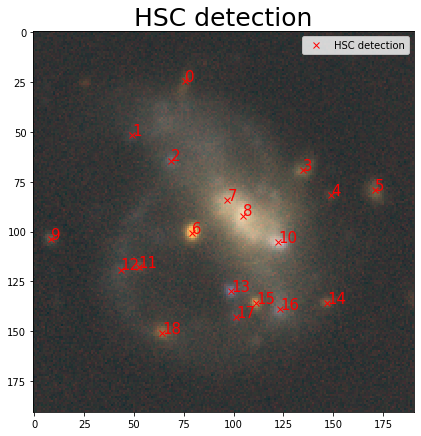

In [4]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=5, Q=1)

# Get the source coordinates from the HST catalog
xc,yc = catalog_hsc['x'], catalog_hsc['y']
rac, decc= wcs.wcs_pix2world(yc,xc, 0)
# Convert the HST coordinates to the HSC WCS
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(cube, norm=hsc_norm)

plt.figure(figsize=(21,7))

plt.imshow(img_rgb)
#plt.axis('off')

for k, x in enumerate(xc):
    plt.text(xc[k], yc[k], str(k), color="r", fontsize = 15)
plt.plot(xc,yc, 'xr', label = 'HSC detection')
plt.legend()
plt.title("HSC detection", fontsize = 25)

plt.show()

In [5]:
#Scarlet specific preparations:
#We let scarlet know about where the data lives
obs_hsc = scarlet.Observation(cube, wcs=wcs, psfs=psfs, channels=channels, weights=weights)

from functools import partial
#Target psf: Determines to which psf the model is deconvolved. Using the same as in observations leads to no deconvolution
#Remove psfs and uncomment for partial deconvolution
model_psf = psfs#scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))

#We let scarlet know in what frame we want our models to live
HSC_frame = scarlet.Frame(
    cube.shape,
    wcs = wcs,
    psfs=model_psf,
    channels=channels)
#Observations meet model. Computes operators that project models onto observations
obs_hsc.match(HSC_frame)

In [6]:
#Display function
def display_init(blend, obs, data, ids, img, title, save = False):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data", fontsize=20)
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model", fontsize=20)
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals", fontsize=20)
    if save is True:
        plt.savefig(title+'_'+str(coord[0])+'_'+str(coord[1])+'.png')
    pass

No flux above threshold for source at y=24 x=75
No flux above threshold for source at y=51 x=48
No flux above threshold for source at y=81 x=148
No flux above threshold for source at y=79 x=171
No flux above threshold for source at y=103 x=8
No flux above threshold for source at y=117 x=52
No flux above threshold for source at y=119 x=43
No flux above threshold for source at y=135 x=146
No flux above threshold for source at y=150 x=64


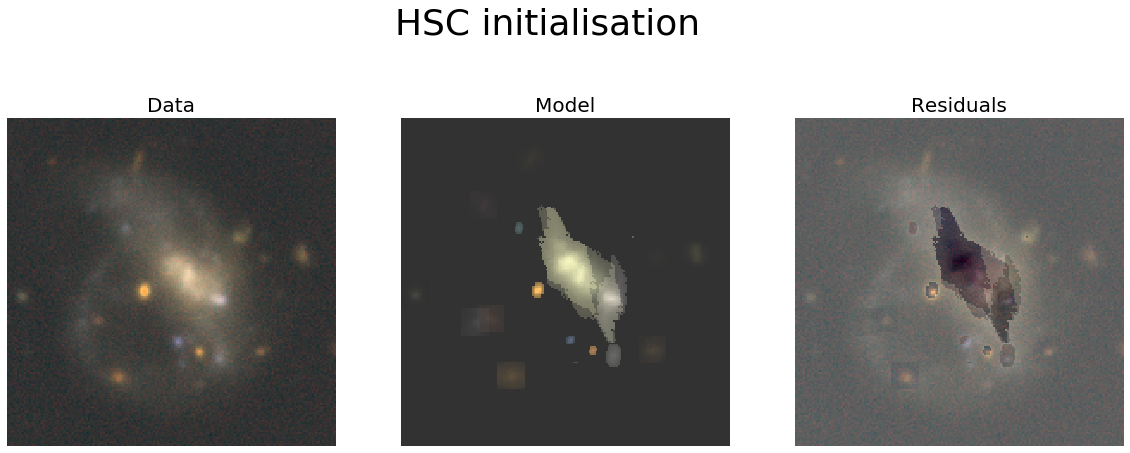

In [7]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hsc)

# Source initialisation: MAkes a first guess as to te source profiles and seds
#Here all sources are extended sources which is a sort of a vaniulla agnostic scarlet run.
HSC_sources = [
    scarlet.ExtendedSource(HSC_frame, (rac[i], decc[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True, 
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           min_grad = 0)
    for i in range(rac.size)
]

blend_hsc = scarlet.Blend(HSC_sources, obs_hsc)
display_init(blend_hsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

scarlet ran for 200 iterations to logL = 84579.07898744286


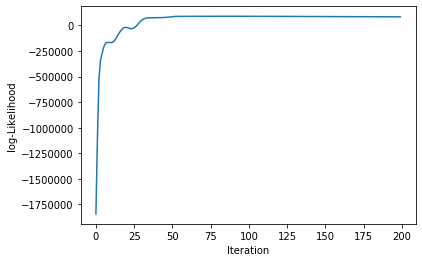

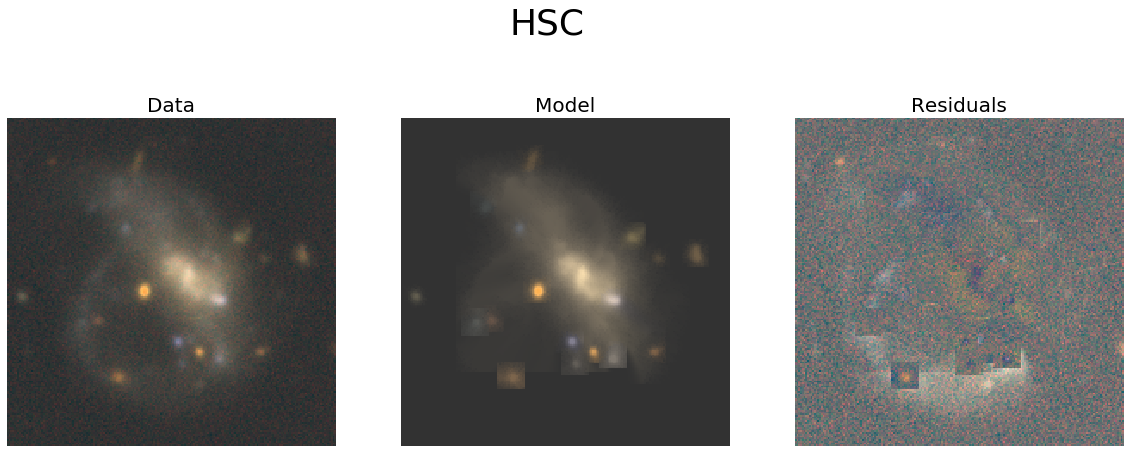

In [8]:
#Runs vanilla scarlet and plots convergence
blend_hsc.fit(200, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hsc.loss), -blend_hsc.loss[-1]))
plt.plot(-np.array(blend_hsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_hsc, obs_hsc, cube, 0, img_rgb, 'HSC', save = 0)

In [9]:
# Modifications to the scarlet base functions and classes

def init_extended_source(
    sky_coord,
    frame,
    observations,
    coadd=None,
    bg_cutoff=None,
    thresh=1,
    symmetric=True,
    monotonic="flat",
    min_grad=0.1,
):
    """Initialize the source that is symmetric and monotonic
    See `ExtendedSource` for a description of the parameters
    """
    try:
        iter(observations)
    except TypeError:
        observations = [observations]
    # determine initial SED from peak position
    # SED in the frame for source detection
    seds = []
    for obs in observations:
        if type(obs) is scarlet.LowResObservation:
            norm = "sum"
        else:
            norm = "max"
        _sed = scarlet.get_psf_sed(sky_coord, obs, frame, normalization=norm)
        seds.append(_sed)

    sed = np.concatenate(seds).flatten()
    if np.all(sed <= 0):
        # If the flux in all channels is  <=0,
        msg = f"Zero or negative SED {sed} at y={sky_coord[0]}, x={sky_coord[1]}"
        logger.warning(msg)
    if coadd is None:
        # which observation to use for detection and morphology
        try:
            bg_rms = np.array([[1 / np.sqrt(w[w > 0].mean()) for w in obs_.weights] for obs_ in observations])
        except:
            raise AttributeError(
                "Observation.weights missing! Please set inverse variance weights"
            )
        coadd, bg_cutoff = build_sed_coadd(seds, bg_rms, observations)
    else:
        if bg_cutoff is None:
            raise AttributeError(
                "background cutoff missing! Please set argument bg_cutoff"
            )
    # Apply the necessary constraints
    center = frame.get_pixel(sky_coord)
    if symmetric:
        morph = scarlet.operator.prox_uncentered_symmetry(
            coadd.copy(), 0, center=center, algorithm="sdss" # *1 is to artificially pass a variable that is not coadd
        )
    else:
        morph = coadd
    if monotonic:
        if monotonic is True:
            monotonic = "angle"
        # use finite thresh to remove flat bridges
        prox_monotonic = scarlet.operator.prox_weighted_monotonic(
            morph.shape, neighbor_weight=monotonic, center=center, min_gradient=min_grad
        )
        morph = prox_monotonic(morph, 0).reshape(morph.shape)
    origin = (np.array(frame.shape)/2).astype(int)
    origin[0]=0
    bbox = scarlet.Box(frame.shape,(0,0,0))

    #morph, bbox = trim_morphology(sky_coord, frame, morph, bg_cutoff, thresh)
    return sed, morph, bbox

class Starlet_FixSED(scarlet.FunctionComponent):
    """Source intialized with starlet coefficients.

    Sources are initialized with the SED of the center pixel,
    and the morphologies are initialised as ExtendedSources
    and transformed into starlet coefficients.
    """
    def __init__(
        self,
        frame,
        sky_coord,
        observations,
        coadd=None,
        bg_cutoff=None,
        thresh=1.0,
        starlet_thresh=5,
        min_grad=0.1,
        sed0 = None,
    ):
        """Extended source intialized to match a set of observations

        Parameters
        ----------
        frame: `~scarlet.Frame`
            The frame of the model
        sky_coord: tuple
            Center of the source
        observations: instance or list of `~scarlet.observation.Observation`
            Observation(s) to initialize this source.
        obs_idx: int
            Index of the observation in `observations` to
            initialize the morphology.
        thresh: `float`
            Multiple of the backround RMS used as a
            flux cutoff for morphology initialization.
        shifting: `bool`
            Whether or not a subpixel shift is added as optimization parameter
        """
        center = np.array(frame.get_pixel(sky_coord), dtype="float")
        self.pixel_center = tuple(np.round(center).astype("int"))

        # initialize SED from sky_coord
        try:
            iter(observations)
        except TypeError:
            observations = [observations]

        # initialize from observation
        sed, image_morph, bbox = init_extended_source(
            sky_coord,
            frame,
            observations,
            coadd=coadd,
            bg_cutoff=bg_cutoff,
            thresh=thresh,
            symmetric=True,
            monotonic=True,
            min_grad=min_grad,
        )

        if sed0 is not None:
            sed = sed0
            
        noise =[]
        for obs in observations:
            noise += [mad_wavelet(obs.images) * \
                    np.sqrt(np.sum(obs._diff_kernels.image**2, axis = (-2,-1)))]
        noise = np.concatenate(noise)
        # Threshold in units of noise
        thresh = starlet_thresh * np.sqrt(np.sum((sed*noise) ** 2))

        # Starlet transform of morphologies (n1,n2) with 4 dimensions: (1,lvl,n1,n2), lvl = wavelet scales
        self.transform = Starlet(image_morph)
        #The starlet transform is the model
        morph = self.transform.coefficients
        # wavelet-scale norm
        starlet_norm = self.transform.norm
        #One threshold per wavelet scale: thresh*norm
        thresh_array = np.zeros(morph.shape) + thresh
        thresh_array = thresh_array * np.array([starlet_norm])[..., np.newaxis, np.newaxis]
        # We don't threshold the last scale
        thresh_array[:,-1,:,:] = 0

        sed = scarlet.Parameter(
            sed,
            name="sed",
            step=partial(scarlet.relative_step, factor=1.e-8),
            constraint=scarlet.PositivityConstraint(),
        )

        morph_constraint = scarlet.ConstraintChain(*[scarlet.L0Constraint(thresh_array), scarlet.PositivityConstraint()])

        morph = scarlet.Parameter(morph, name="morph", step=1.e-2, constraint=morph_constraint)

        super().__init__(frame, bbox, sed, morph, self._iuwt)
        
    @property
    def center(self):
        if len(self.parameters) == 3:
            return self.pixel_center + self.shift
        else:
            return self.pixel_center

    def _iuwt(self, param):
        """ Takes the inverse transform of parameters as starlet coefficients.

        """
        return Starlet(coefficients = param).image[0]

In [10]:
#Now let's try with wavelets: 

#Source initialisation. Here we decide which sources from the detection step should be modeled with wavelets.

#Keep in mind that the choices made here were for a given source detection level. Most of them are set for lvl=2. Source 6 needs lvl = 4.
#If results look weird, try to changing the detection lvl to obtain something that makes sense. 
if i == '18':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==23 or i == 25:
        
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                           (rac[i], decc[i]), obs_hsc,  
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           sed0 = sedi,
                           min_grad = 0, 
                                  starlet_thresh = 3)
            wave_sources[i] = newsource

elif i =='6':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==1 or i==8:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
    wave_sources =np.delete(wave_sources, 12)
    wave_sources =np.delete(wave_sources, 7)
elif i =='25':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==32 or i == 44:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='12':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==13 or i == 28:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='7':
    wave_sources = []#np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==10 or i == 11:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources.append(newsource)
        if i==19 or i==20 or i==1 or i==5 or i==6 or i==15 or i==14:
            newsource = scarlet.ExtendedSource(HSC_frame, (rac[i], decc[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True, 
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           min_grad = 0)
            wave_sources.append(newsource)
elif i =='22':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==17 or i == 16:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
            
elif i =='19':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==27 or i == 28:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='17':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==3:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='15':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==14:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource   
elif i =='14':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==5:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource   
    
    wave_sources = np.delete(wave_sources, 9)
    wave_sources = np.delete(wave_sources, 7)    
    wave_sources = np.delete(wave_sources, 6)
    wave_sources = np.delete(wave_sources, 4)
elif i =='10':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==17 or i==28:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = Starlet_FixSED(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               sed0 = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource   
    wave_sources = np.delete(wave_sources, 31) 
    wave_sources = np.delete(wave_sources, 29) 
    wave_sources = np.delete(wave_sources, 23) 
    wave_sources = np.delete(wave_sources, 19)
    wave_sources = np.delete(wave_sources, 16) 
    wave_sources = np.delete(wave_sources, 18)    
    wave_sources = np.delete(wave_sources, 15)

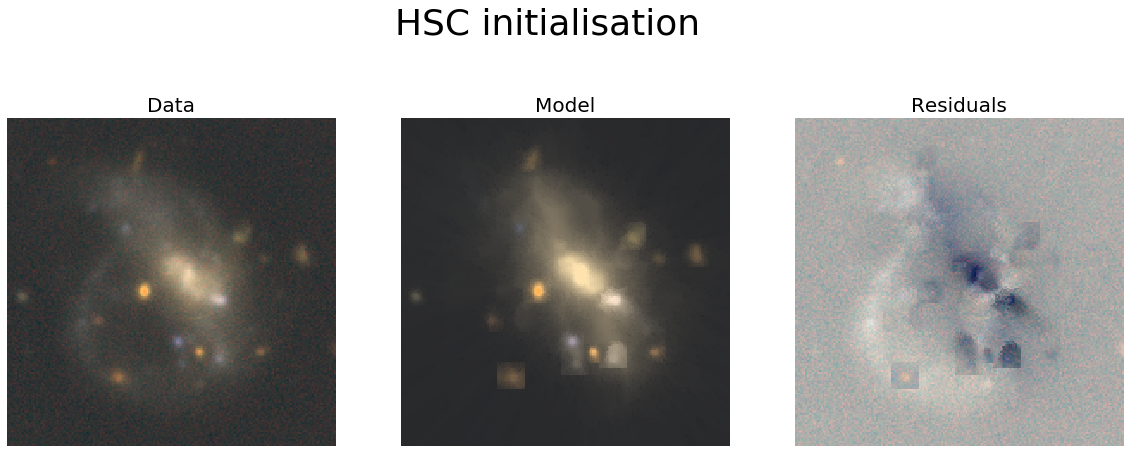

In [11]:
#Display first guess with wavelets
blend_wavehsc = scarlet.Blend(wave_sources, obs_hsc)

display_init(blend_wavehsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

scarlet ran for 200 iterations to logL = 170928.29948265007


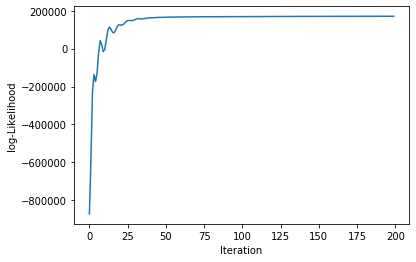

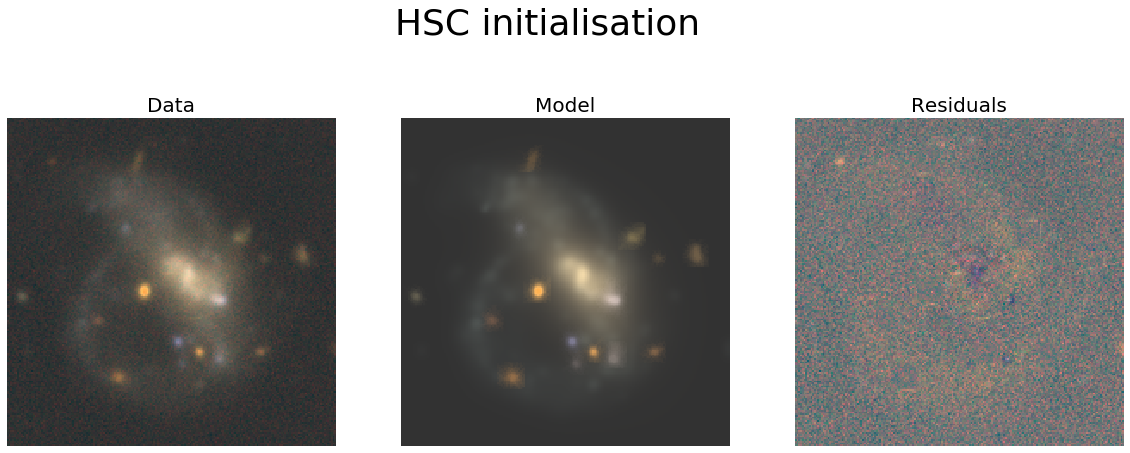

In [12]:
#Runs scarlet with wavelets
blend_wavehsc.fit(200, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_wavehsc.loss), -blend_wavehsc.loss[-1]))
plt.plot(-np.array(blend_wavehsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_wavehsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

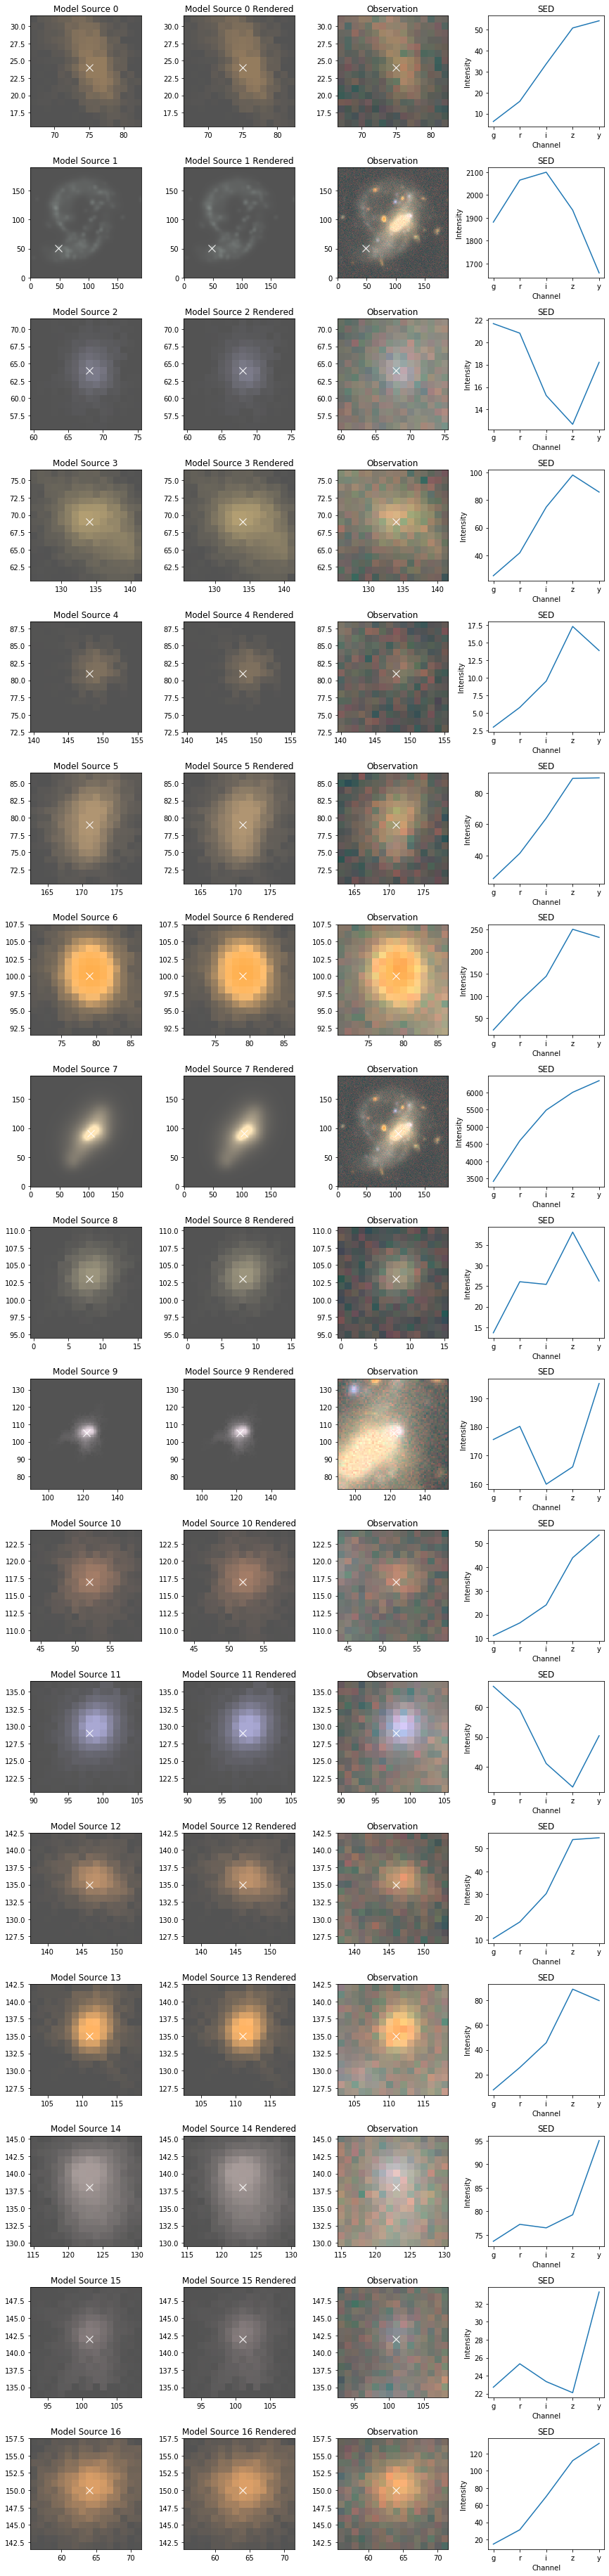

In [13]:
#Show results
hsc_norm = AsinhMapping(minimum=-1, stretch=3, Q=1)

scarlet.display.show_sources(wave_sources, 
                             norm=hsc_norm, 
                             observation=obs_hsc,
                             show_rendered=True, 
                             show_observed=True)
plt.show()